In [1]:
from mhadatareader import MhaDataReader
from classes import ParticipantsData, Scan, ProficiencyLabel, FoldSplit
import utils as ut
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import random
from tensorflow.keras.utils import plot_model
from sklearn.metrics import recall_score, confusion_matrix

import os 

In [2]:
DIR_NAME = './data_bckp'
MODEL_NAME = 'best_model.tf'
LOG_DIR = './logs'

In [3]:
def save_model(model, fold):
    model.save(f'./best_model_{fold}.tf')

In [4]:
novices_all, intermed_all, experts_all = ut.load_data(DIR_NAME)
prepared = ut.prepare_data(novices_all, intermed_all, experts_all)
slice_window = 500
print(slice_window)

500


In [117]:
folds_stats = []
models_train_hist = dict()

# hyper-parameters #
kernel_size = 5
filters = 64
epochs = 300
batch_size = 32
dropout_rate = 0.5
learning_rate = 0.0001

CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=10, 
        min_lr=0.000001),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        verbose=1,
    )
]
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
iterations = list(it.permutations([i for i in range(len(prepared[ut.Scan.ALL]))]))
regularizer = keras.regularizers.l1_l2(0.05)

In [6]:
def build_model(input_shape, num_classes, filters, kernel_size, dropout_rate, regularizer):
    input_layer = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", 
                                kernel_regularizer=regularizer,
                                activation='relu')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(dropout_rate)(conv1)
    
    conv2 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(dropout_rate)(conv2)

    conv3 = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(dropout_rate)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [118]:
novices_all, intermed_all, experts_all = prepared[ut.Scan.ALL]
folds_all = ut.form_folds(novices_all, intermed_all, experts_all)

for i in range(len(iterations)):
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_train, y_train = train
    x_val, y_val = valid
    x_test, y_test = test
    
    print(f'Running fold {i + 1}')
    
    model = build_model(
        x_train.shape[1:], 
        len(ProficiencyLabel), 
        kernel_size=kernel_size, 
        filters=filters, 
        dropout_rate=dropout_rate, 
        regularizer=regularizer
    )
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    plot_model(model, to_file='model.png')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=CALLBACKS,
        validation_data=(x_val, y_val),
        verbose=1,
    )
    
    models_train_hist[i] = history.history

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy', test_acc)
    print('Test loss', test_loss)
    
    save_model(model, i)

    folds_stats.append((test_loss, test_acc))

Running fold 1
Epoch 1/300
691/691 [==============================] - 11s 15ms/step - loss: 246.3909 - sparse_categorical_accuracy: 0.6017 - val_loss: 7.1341 - val_sparse_categorical_accuracy: 0.9047
Epoch 2/300
691/691 [==============================] - 10s 15ms/step - loss: 2.7354 - sparse_categorical_accuracy: 0.9563 - val_loss: 1.0742 - val_sparse_categorical_accuracy: 0.9822
Epoch 3/300
691/691 [==============================] - 10s 14ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.9607 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.9820
Epoch 4/300
691/691 [==============================] - 11s 16ms/step - loss: 1.1201 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.9826
Epoch 5/300
691/691 [==============================] - 12s 17ms/step - loss: 1.1177 - sparse_categorical_accuracy: 0.9650 - val_loss: 1.0301 - val_sparse_categorical_accuracy: 0.9826
Epoch 6/300
691/691 [==============================] - 10s 15ms/step

KeyboardInterrupt: 

In [8]:
mean_all = []
for i in range(6):
    mean_all.append(models_train_hist[i]['sparse_categorical_accuracy'][-1])
    

In [9]:
np.mean(mean_all)

0.9777091244856516

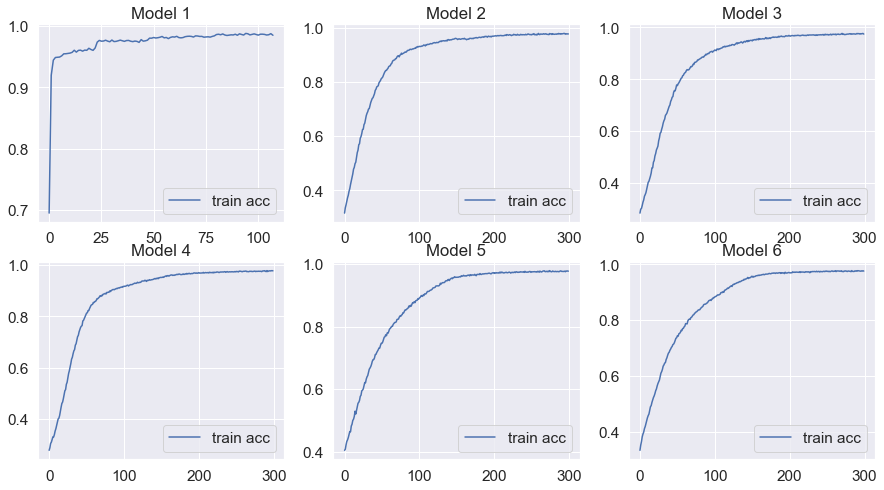

In [116]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['sparse_categorical_accuracy']) 
        #axs[i,j].plot(models_train_hist[i + j]['val_loss'])
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].legend(['train acc',], loc='best')
        cnt += 1
    
    
plt.show()
fib.savefig('./training_acc.png', bbox_inches='tight', pad_inches=0)


In [11]:
folds_stats_t = folds_stats

avg_acc = 0
for i in range(len(folds_stats_t)):
    avg_acc = avg_acc + folds_stats_t[i][1]
    if i == len(folds_stats_t) - 1:
        avg_acc = avg_acc / len(folds_stats_t)

avg_loss = 0
for i in range(len(folds_stats_t)):
    avg_loss = avg_loss + folds_stats_t[i][0]
    if i == len(folds_stats_t) - 1:
        avg_loss = avg_loss / len(folds_stats_t)

print(f'AVG test acc: {avg_acc}')
print(f'AVG test loss: {avg_loss}')
print(folds_stats_t)

AVG test acc: 0.9645562668641409
AVG test loss: 0.22483771046002707
[(0.12500101327896118, 0.9931786060333252), (0.22666694223880768, 0.9826022982597351), (0.1786983162164688, 0.9762477278709412), (0.3025338649749756, 0.9306196570396423), (0.20597290992736816, 0.9820750951766968), (0.31015321612358093, 0.9226142168045044)]


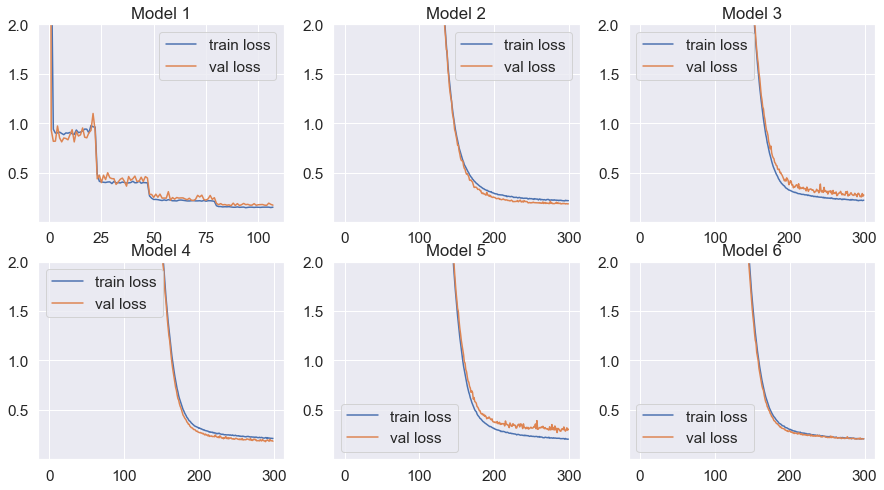

In [115]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['loss']) 
        axs[i,j].plot(models_train_hist[cnt]['val_loss'])
        #print(f'MIN for {i + j} {np.min(models_train_hist[i + j]['val_loss'])}')
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].set_ylim(0.0001, 2)
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)

In [13]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

mean_train_loss = []
mean_val_loss = []

for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[i + j]['loss']) 
        axs[i,j].plot(models_train_hist[i + j]['val_loss'])
        print(f'MIN for {i + j} {np.min(models_train_hist[i + j]['val_loss'])}')
        axs[i,j].set_title(f'Model {cnt}')
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
fib.savefig('./dist_acc.png', bbox_inches='tight', pad_inches=0)

SyntaxError: invalid syntax (<ipython-input-13-4d9ab318c3ca>, line 10)

## Finetuning

In [28]:
fine_models_train_hist = dict()
fine_folds_stats = dict()

for i in range(6):
    fine_models_train_hist[i] = dict()
    fine_folds_stats[i] = dict()
    for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
        fine_models_train_hist[i][reg] = dict()
        fine_folds_stats[i][reg] = []

In [119]:
# hyper-parameters #
fine_epochs = 50
fine_batch_size = 32
fine_kernel_size = 7
fine_filters = 64
fine_dropout_rate = 0.7
fine_learning_rate = 0.00001
fine_regularizer = keras.regularizers.l1_l2(0.07)
fine_CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001
    ),
]

In [120]:
def load_model(num, reg):
    build = True
    
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    if (os.path.exists(m_name_tuned)):
        print(f'loading prev tuned {m_name_tuned}')
        return keras.models.load_model(m_name_tuned), not build

    m_name_untuned = f'./best_model_{num}.tf'
    print(f'loading non-tuned {m_name_untuned}')
    return keras.models.load_model(m_name_untuned), build


def save_model_tune(model, num, reg):
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    
    print(f'saving {m_name_tuned}')
    model.save(m_name_tuned)

def build_model_funetune(base_model, input_shape, num_classes, filters, 
                         kernel_size, dropout_rate, regularizer):
    assert base_model is not None
    model = keras.Sequential()
    
    # freeze the base model
    base_model.trainable = False
    # add all layers except the last two
    for layer in base_model.layers[:-2]: 
        model.add(layer)

    model.add(keras.layers.Conv1D(filters=filters, 
                            kernel_size=kernel_size, padding="same", 
                            kernel_regularizer=regularizer,
                            activation='relu',
                            name=f'Conv1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.BatchNormalization(
        name=f'BatchNormalization_{str(len(model.layers) + 1)}'
    ))
    model.add(keras.layers.Dropout(dropout_rate,
                                  name=f'Dropout_{str(len(model.layers) + 1)}'
                                  ))

    model.add(keras.layers.GlobalAveragePooling1D(name=f'GlobalAveragePooling1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.Dense(num_classes, activation='softmax',
                                 name=f'Dense_{str(len(model.layers) + 1)}'))
        
    model.compile(
                optimizer=keras.optimizers.Adam(
                    learning_rate=learning_rate
                ),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
    
    return model

In [31]:
print(iterations)

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


## Region training

In [121]:
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        
        print(f'Running fold on {reg} {i + 1}')
        print(f'Loading model {i} for region {reg}')
        model, build = load_model(i, reg.name)
        if build:
            print(f'building model {reg} {i}')
            model = build_model_funetune(
                model,
                x_train.shape[1:], 
                len(ProficiencyLabel), 
                kernel_size=fine_kernel_size, 
                filters=fine_filters, 
                dropout_rate=fine_dropout_rate, 
                regularizer=fine_regularizer,
            )
        
        
        history = model.fit(
            x_train,
            y_train,
            batch_size=fine_batch_size,
            epochs=fine_epochs,
            callbacks=fine_CALLBACKS,
            validation_data=(x_val, y_val),
            verbose=1,
        )
        fine_models_train_hist[i][reg] = history.history

        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f'Test accuracy {reg}', test_acc)
        print(f'Test loss {reg}', test_loss)

        save_model_tune(model, i, reg)

        fine_folds_stats[i][reg].append((test_loss, test_acc))

Running fold on Scan.LUQ 1
Loading model 0 for region Scan.LUQ
loading non-tuned ./best_model_0.tf
building model Scan.LUQ 0
Epoch 1/50
171/171 [==============================] - 3s 9ms/step - loss: 75.5858 - sparse_categorical_accuracy: 0.3982 - val_loss: 53.1110 - val_sparse_categorical_accuracy: 0.3725
Epoch 2/50
171/171 [==============================] - 1s 6ms/step - loss: 46.7671 - sparse_categorical_accuracy: 0.5671 - val_loss: 29.5543 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/50
171/171 [==============================] - 1s 6ms/step - loss: 25.0743 - sparse_categorical_accuracy: 0.7311 - val_loss: 13.0432 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/50
171/171 [==============================] - 1s 8ms/step - loss: 10.3969 - sparse_categorical_accuracy: 0.8733 - val_loss: 3.5409 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/50
171/171 [==============================] - 1s 6ms/step - loss: 2.5340 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5958 - val_spar

171/171 [==============================] - 1s 7ms/step - loss: 0.1571 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.1595 - val_sparse_categorical_accuracy: 1.0000
Epoch 46/50
171/171 [==============================] - 1s 7ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 1.0000
Epoch 47/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.1630 - val_sparse_categorical_accuracy: 1.0000
Epoch 48/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1551 - val_sparse_categorical_accuracy: 1.0000
Epoch 49/50
171/171 [==============================] - 1s 7ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1812 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/50
95/95 [==============================] - 1s 3ms/step - loss: 0.1814 - sparse_categorical_accura

171/171 [==============================] - 1s 6ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.1875 - val_sparse_categorical_accuracy: 1.0000
Epoch 39/50
171/171 [==============================] - 1s 8ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.1802 - val_sparse_categorical_accuracy: 1.0000
Epoch 40/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1941 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1902 - val_sparse_categorical_accuracy: 1.0000
Epoch 41/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1883 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.1989 - val_sparse_categorical_accuracy: 1.0000
Epoch 42/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1806 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.1828 - val_sparse_categorical_accuracy: 1.0000
Epoch 43/50
171/171 [==============================] - 1s 6ms/step - loss: 0.1862 - sparse_categorical_accu

96/96 [==============================] - 1s 9ms/step - loss: 0.2227 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.2033 - val_sparse_categorical_accuracy: 1.0000
Epoch 32/50
96/96 [==============================] - 1s 9ms/step - loss: 0.2174 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2007 - val_sparse_categorical_accuracy: 1.0000
Epoch 33/50
96/96 [==============================] - 1s 11ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.2042 - val_sparse_categorical_accuracy: 1.0000
Epoch 34/50
96/96 [==============================] - 1s 12ms/step - loss: 0.2191 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.2009 - val_sparse_categorical_accuracy: 1.0000
Epoch 35/50
96/96 [==============================] - 1s 9ms/step - loss: 0.2120 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.1973 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/50
96/96 [==============================] - 1s 9ms/step - loss: 0.2130 - sparse_categorical_accuracy: 0.99

96/96 [==============================] - 1s 7ms/step - loss: 0.2417 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 1.0000
Epoch 25/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2365 - val_sparse_categorical_accuracy: 1.0000
Epoch 26/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.2268 - val_sparse_categorical_accuracy: 1.0000
Epoch 27/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2314 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.2334 - val_sparse_categorical_accuracy: 1.0000
Epoch 28/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.2289 - val_sparse_categorical_accuracy: 1.0000
Epoch 29/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2314 - sparse_categorical_accuracy: 0.9976

95/95 [==============================] - 1s 9ms/step - loss: 0.3452 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.2489 - val_sparse_categorical_accuracy: 1.0000
Epoch 18/50
95/95 [==============================] - 1s 9ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.2514 - val_sparse_categorical_accuracy: 1.0000
Epoch 19/50
95/95 [==============================] - 1s 8ms/step - loss: 0.3075 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.2437 - val_sparse_categorical_accuracy: 1.0000
Epoch 20/50
95/95 [==============================] - 1s 9ms/step - loss: 0.3030 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.2388 - val_sparse_categorical_accuracy: 1.0000
Epoch 21/50
95/95 [==============================] - 1s 9ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.2364 - val_sparse_categorical_accuracy: 1.0000
Epoch 22/50
95/95 [==============================] - 1s 8ms/step - loss: 0.2846 - sparse_categorical_accuracy: 0.9977

95/95 [==============================] - 1s 7ms/step - loss: 0.4846 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.3660 - val_sparse_categorical_accuracy: 1.0000
Epoch 11/50
95/95 [==============================] - 1s 9ms/step - loss: 0.4511 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.3380 - val_sparse_categorical_accuracy: 1.0000
Epoch 12/50
95/95 [==============================] - 1s 8ms/step - loss: 0.4403 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.3202 - val_sparse_categorical_accuracy: 1.0000
Epoch 13/50
95/95 [==============================] - 1s 8ms/step - loss: 0.4049 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 1.0000
Epoch 14/50
95/95 [==============================] - 1s 7ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.3021 - val_sparse_categorical_accuracy: 1.0000
Epoch 15/50
95/95 [==============================] - 1s 7ms/step - loss: 0.3599 - sparse_categorical_accuracy: 0.9922

86/86 [==============================] - 1s 7ms/step - loss: 49.8528 - sparse_categorical_accuracy: 0.8359 - val_loss: 40.3191 - val_sparse_categorical_accuracy: 0.9964
Epoch 4/50
86/86 [==============================] - 1s 8ms/step - loss: 37.5531 - sparse_categorical_accuracy: 0.8853 - val_loss: 29.3298 - val_sparse_categorical_accuracy: 0.9984
Epoch 5/50
86/86 [==============================] - 1s 7ms/step - loss: 27.0215 - sparse_categorical_accuracy: 0.9332 - val_loss: 20.1336 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/50
86/86 [==============================] - 1s 7ms/step - loss: 18.2625 - sparse_categorical_accuracy: 0.9617 - val_loss: 12.7190 - val_sparse_categorical_accuracy: 1.0000
Epoch 7/50
86/86 [==============================] - 1s 8ms/step - loss: 11.2589 - sparse_categorical_accuracy: 0.9764 - val_loss: 7.0201 - val_sparse_categorical_accuracy: 1.0000
Epoch 8/50
86/86 [==============================] - 1s 7ms/step - loss: 5.9991 - sparse_categorical_accuracy: 0.

Epoch 49/50
86/86 [==============================] - 1s 8ms/step - loss: 0.2024 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/50
127/127 [==============================] - 0s 3ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.9051
Test accuracy Scan.RUQ 0.9051256775856018
Test loss Scan.RUQ 0.3354825973510742
saving ./best_model_tuned_0_Scan.RUQ.tf
INFO:tensorflow:Assets written to: ./best_model_tuned_0_Scan.RUQ.tf/assets
Running fold on Scan.RUQ 2
Loading model 1 for region Scan.RUQ
loading non-tuned ./best_model_1.tf
building model Scan.RUQ 1
Epoch 1/50
86/86 [==============================] - 2s 12ms/step - loss: 79.2516 - sparse_categorical_accuracy: 0.6416 - val_loss: 67.2116 - val_sparse_categorical_accuracy: 0.7883
Epoch 2/50
86/86 [==============================] - 1s 9ms/step - loss: 63.3053 - sparse_categorical_accuracy: 0.7988 - val_loss: 52.6810 - val_sparse_categorical_accuracy: 0.7920
Epoch 3/50
86/86 [==

86/86 [==============================] - 1s 8ms/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.9623
Epoch 43/50
86/86 [==============================] - 1s 9ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.5246 - val_sparse_categorical_accuracy: 0.8568
Epoch 44/50
86/86 [==============================] - 1s 8ms/step - loss: 0.2465 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.4573 - val_sparse_categorical_accuracy: 0.8620
Epoch 45/50
86/86 [==============================] - 1s 9ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.9349
Epoch 46/50
86/86 [==============================] - 1s 8ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.4005 - val_sparse_categorical_accuracy: 0.8815
Epoch 47/50
86/86 [==============================] - 1s 9ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9961

96/96 [==============================] - 1s 7ms/step - loss: 0.2671 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.2502 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/50
96/96 [==============================] - 1s 7ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.2433 - val_sparse_categorical_accuracy: 1.0000
Epoch 37/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.2622 - val_sparse_categorical_accuracy: 1.0000
Epoch 38/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2687 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.2477 - val_sparse_categorical_accuracy: 1.0000
Epoch 39/50
96/96 [==============================] - 1s 9ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.2517 - val_sparse_categorical_accuracy: 1.0000
Epoch 40/50
96/96 [==============================] - 1s 9ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9948

96/96 [==============================] - 1s 8ms/step - loss: 0.3408 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.8783
Epoch 29/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.4552 - val_sparse_categorical_accuracy: 0.8674
Epoch 30/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2932 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.4580 - val_sparse_categorical_accuracy: 0.8635
Epoch 31/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2868 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.8931
Epoch 32/50
96/96 [==============================] - 1s 8ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.4420 - val_sparse_categorical_accuracy: 0.8743
Epoch 33/50
96/96 [==============================] - 1s 8ms/step - loss: 0.2926 - sparse_categorical_accuracy: 0.9931

127/127 [==============================] - 1s 8ms/step - loss: 0.3412 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.2489 - val_sparse_categorical_accuracy: 1.0000
Epoch 22/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3430 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.2378 - val_sparse_categorical_accuracy: 1.0000
Epoch 23/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.9686 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 1.0000
Epoch 24/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3318 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.2469 - val_sparse_categorical_accuracy: 1.0000
Epoch 25/50
127/127 [==============================] - 1s 9ms/step - loss: 0.3292 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.2374 - val_sparse_categorical_accuracy: 1.0000
Epoch 26/50
127/127 [==============================] - 1s 9ms/step - loss: 0.3286 - sparse_categorical_accu

127/127 [==============================] - 1s 7ms/step - loss: 0.4177 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.3076 - val_sparse_categorical_accuracy: 1.0000
Epoch 15/50
127/127 [==============================] - 1s 9ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.3003 - val_sparse_categorical_accuracy: 1.0000
Epoch 16/50
127/127 [==============================] - 1s 7ms/step - loss: 0.4031 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 1.0000
Epoch 17/50
127/127 [==============================] - 1s 7ms/step - loss: 0.3723 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.2908 - val_sparse_categorical_accuracy: 1.0000
Epoch 18/50
127/127 [==============================] - 1s 10ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.2761 - val_sparse_categorical_accuracy: 1.0000
Epoch 19/50
127/127 [==============================] - 1s 8ms/step - loss: 0.3665 - sparse_categorical_acc

Epoch 7/50
15/15 [==============================] - 0s 34ms/step - loss: 66.2725 - sparse_categorical_accuracy: 0.3927 - val_loss: 64.0958 - val_sparse_categorical_accuracy: 0.8222
Epoch 8/50
15/15 [==============================] - 0s 23ms/step - loss: 63.6240 - sparse_categorical_accuracy: 0.4170 - val_loss: 61.5154 - val_sparse_categorical_accuracy: 0.8222
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 61.0460 - sparse_categorical_accuracy: 0.4195 - val_loss: 58.9854 - val_sparse_categorical_accuracy: 0.8222
Epoch 10/50
15/15 [==============================] - 0s 19ms/step - loss: 58.5120 - sparse_categorical_accuracy: 0.4336 - val_loss: 56.5118 - val_sparse_categorical_accuracy: 0.8222
Epoch 11/50
15/15 [==============================] - 0s 19ms/step - loss: 56.0536 - sparse_categorical_accuracy: 0.4158 - val_loss: 54.0950 - val_sparse_categorical_accuracy: 0.8222
Epoch 12/50
15/15 [==============================] - 0s 21ms/step - loss: 53.6448 - sparse_ca

INFO:tensorflow:Assets written to: ./best_model_tuned_0_Scan.PERICARD.tf/assets
Running fold on Scan.PERICARD 2
Loading model 1 for region Scan.PERICARD
loading non-tuned ./best_model_1.tf
building model Scan.PERICARD 1
Epoch 1/50
15/15 [==============================] - 1s 29ms/step - loss: 83.4417 - sparse_categorical_accuracy: 0.3977 - val_loss: 81.1803 - val_sparse_categorical_accuracy: 0.6158
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 80.5148 - sparse_categorical_accuracy: 0.3940 - val_loss: 78.2467 - val_sparse_categorical_accuracy: 0.6158
Epoch 3/50
15/15 [==============================] - 0s 9ms/step - loss: 77.6033 - sparse_categorical_accuracy: 0.3790 - val_loss: 75.3752 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 11ms/step - loss: 74.6567 - sparse_categorical_accuracy: 0.4510 - val_loss: 72.5617 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================]

Epoch 45/50
15/15 [==============================] - 0s 9ms/step - loss: 4.9163 - sparse_categorical_accuracy: 0.8468 - val_loss: 5.0178 - val_sparse_categorical_accuracy: 0.3842
Epoch 46/50
15/15 [==============================] - 0s 9ms/step - loss: 4.3042 - sparse_categorical_accuracy: 0.8710 - val_loss: 4.5266 - val_sparse_categorical_accuracy: 0.3842
Epoch 47/50
15/15 [==============================] - 0s 9ms/step - loss: 3.7865 - sparse_categorical_accuracy: 0.8968 - val_loss: 4.0318 - val_sparse_categorical_accuracy: 0.3842
Epoch 48/50
15/15 [==============================] - 0s 9ms/step - loss: 3.2921 - sparse_categorical_accuracy: 0.9047 - val_loss: 3.5369 - val_sparse_categorical_accuracy: 0.3842
Epoch 49/50
15/15 [==============================] - 0s 9ms/step - loss: 2.8576 - sparse_categorical_accuracy: 0.9221 - val_loss: 3.1741 - val_sparse_categorical_accuracy: 0.3842
Epoch 50/50
67/67 [==============================] - 0s 3ms/step - loss: 2.2242 - sparse_categorical_accu

67/67 [==============================] - 0s 5ms/step - loss: 0.2222 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1955 - val_sparse_categorical_accuracy: 1.0000
Epoch 39/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.1949 - val_sparse_categorical_accuracy: 1.0000
Epoch 40/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2100 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1966 - val_sparse_categorical_accuracy: 1.0000
Epoch 41/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2141 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1977 - val_sparse_categorical_accuracy: 1.0000
Epoch 42/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2120 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2064 - val_sparse_categorical_accuracy: 1.0000
Epoch 43/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9998

67/67 [==============================] - 0s 7ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.2215 - val_sparse_categorical_accuracy: 1.0000
Epoch 32/50
67/67 [==============================] - 0s 7ms/step - loss: 0.2503 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.2207 - val_sparse_categorical_accuracy: 1.0000
Epoch 33/50
67/67 [==============================] - 0s 6ms/step - loss: 0.2508 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.2149 - val_sparse_categorical_accuracy: 1.0000
Epoch 34/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2489 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.2159 - val_sparse_categorical_accuracy: 1.0000
Epoch 35/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2112 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/50
67/67 [==============================] - 0s 5ms/step - loss: 0.2392 - sparse_categorical_accuracy: 0.9999

18/18 [==============================] - 0s 8ms/step - loss: 21.2198 - sparse_categorical_accuracy: 0.9746 - val_loss: 20.0263 - val_sparse_categorical_accuracy: 1.0000
Epoch 25/50
18/18 [==============================] - 0s 8ms/step - loss: 19.4424 - sparse_categorical_accuracy: 0.9740 - val_loss: 18.3034 - val_sparse_categorical_accuracy: 1.0000
Epoch 26/50
18/18 [==============================] - 0s 8ms/step - loss: 17.7433 - sparse_categorical_accuracy: 0.9850 - val_loss: 16.6622 - val_sparse_categorical_accuracy: 1.0000
Epoch 27/50
18/18 [==============================] - 0s 8ms/step - loss: 16.1536 - sparse_categorical_accuracy: 0.9681 - val_loss: 15.1209 - val_sparse_categorical_accuracy: 1.0000
Epoch 28/50
18/18 [==============================] - 0s 10ms/step - loss: 14.5784 - sparse_categorical_accuracy: 0.9957 - val_loss: 13.6467 - val_sparse_categorical_accuracy: 1.0000
Epoch 29/50
18/18 [==============================] - 0s 8ms/step - loss: 13.1576 - sparse_categorical_accu

18/18 [==============================] - 1s 48ms/step - loss: 36.2451 - sparse_categorical_accuracy: 0.9474 - val_loss: 34.4277 - val_sparse_categorical_accuracy: 1.0000
Epoch 18/50
18/18 [==============================] - 0s 19ms/step - loss: 33.9156 - sparse_categorical_accuracy: 0.9637 - val_loss: 32.1585 - val_sparse_categorical_accuracy: 1.0000
Epoch 19/50
18/18 [==============================] - 0s 18ms/step - loss: 31.6592 - sparse_categorical_accuracy: 0.9628 - val_loss: 29.9687 - val_sparse_categorical_accuracy: 1.0000
Epoch 20/50
18/18 [==============================] - 0s 19ms/step - loss: 29.4922 - sparse_categorical_accuracy: 0.9743 - val_loss: 27.8595 - val_sparse_categorical_accuracy: 1.0000
Epoch 21/50
18/18 [==============================] - 0s 19ms/step - loss: 27.3944 - sparse_categorical_accuracy: 0.9827 - val_loss: 25.8291 - val_sparse_categorical_accuracy: 1.0000
Epoch 22/50
18/18 [==============================] - 0s 21ms/step - loss: 25.3824 - sparse_categorical

Epoch 10/50
52/52 [==============================] - 0s 7ms/step - loss: 16.0104 - sparse_categorical_accuracy: 0.6898 - val_loss: 13.3567 - val_sparse_categorical_accuracy: 0.3304
Epoch 11/50
52/52 [==============================] - 0s 7ms/step - loss: 11.9940 - sparse_categorical_accuracy: 0.7638 - val_loss: 9.9040 - val_sparse_categorical_accuracy: 0.3304
Epoch 12/50
52/52 [==============================] - 0s 8ms/step - loss: 8.6322 - sparse_categorical_accuracy: 0.8207 - val_loss: 7.0832 - val_sparse_categorical_accuracy: 0.3304
Epoch 13/50
52/52 [==============================] - 0s 6ms/step - loss: 5.8860 - sparse_categorical_accuracy: 0.8740 - val_loss: 4.8844 - val_sparse_categorical_accuracy: 0.3304
Epoch 14/50
52/52 [==============================] - 0s 5ms/step - loss: 3.7729 - sparse_categorical_accuracy: 0.9037 - val_loss: 3.2773 - val_sparse_categorical_accuracy: 0.3304
Epoch 15/50
52/52 [==============================] - 0s 6ms/step - loss: 2.2114 - sparse_categorical_a

52/52 [==============================] - 0s 6ms/step - loss: 62.5644 - sparse_categorical_accuracy: 0.4967 - val_loss: 55.8287 - val_sparse_categorical_accuracy: 0.9976
Epoch 4/50
52/52 [==============================] - 0s 6ms/step - loss: 54.0133 - sparse_categorical_accuracy: 0.5115 - val_loss: 47.6732 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/50
52/52 [==============================] - 0s 6ms/step - loss: 46.0627 - sparse_categorical_accuracy: 0.5411 - val_loss: 40.2026 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/50
52/52 [==============================] - 0s 6ms/step - loss: 38.7669 - sparse_categorical_accuracy: 0.5893 - val_loss: 33.3948 - val_sparse_categorical_accuracy: 1.0000
Epoch 7/50
52/52 [==============================] - 0s 6ms/step - loss: 32.1775 - sparse_categorical_accuracy: 0.5780 - val_loss: 27.2616 - val_sparse_categorical_accuracy: 1.0000
Epoch 8/50
52/52 [==============================] - 0s 6ms/step - loss: 26.1729 - sparse_categorical_accuracy: 

Epoch 49/50
52/52 [==============================] - 0s 6ms/step - loss: 0.1729 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1710 - val_sparse_categorical_accuracy: 1.0000
Epoch 50/50
32/32 [==============================] - 0s 2ms/step - loss: 2.9237 - sparse_categorical_accuracy: 0.3304
Test accuracy Scan.PELVIC 0.33037474751472473
Test loss Scan.PELVIC 2.923672676086426
saving ./best_model_tuned_1_Scan.PELVIC.tf
INFO:tensorflow:Assets written to: ./best_model_tuned_1_Scan.PELVIC.tf/assets
Running fold on Scan.PELVIC 3
Loading model 2 for region Scan.PELVIC
loading non-tuned ./best_model_2.tf
building model Scan.PELVIC 2
Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 82.6043 - sparse_categorical_accuracy: 0.2719 - val_loss: 77.9824 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 76.3114 - sparse_categorical_accuracy: 0.4847 - val_loss: 71.9171 - val_sparse_categorical_accuracy: 0.04

32/32 [==============================] - 0s 10ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.3181 - val_sparse_categorical_accuracy: 1.0000
Epoch 43/50
32/32 [==============================] - 0s 11ms/step - loss: 0.3883 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.3304 - val_sparse_categorical_accuracy: 1.0000
Epoch 44/50
32/32 [==============================] - 0s 10ms/step - loss: 0.3608 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.3253 - val_sparse_categorical_accuracy: 1.0000
Epoch 45/50
32/32 [==============================] - 0s 8ms/step - loss: 0.3825 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.3211 - val_sparse_categorical_accuracy: 1.0000
Epoch 46/50
32/32 [==============================] - 0s 8ms/step - loss: 0.3625 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.3161 - val_sparse_categorical_accuracy: 1.0000
Epoch 47/50
32/32 [==============================] - 0s 8ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.9

32/32 [==============================] - 0s 10ms/step - loss: 0.4249 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.4429 - val_sparse_categorical_accuracy: 0.9984
Epoch 36/50
32/32 [==============================] - 0s 10ms/step - loss: 0.4138 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.4472 - val_sparse_categorical_accuracy: 0.9984
Epoch 37/50
32/32 [==============================] - 0s 10ms/step - loss: 0.4264 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.4526 - val_sparse_categorical_accuracy: 0.9984
Epoch 38/50
32/32 [==============================] - 0s 10ms/step - loss: 0.4123 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.4985 - val_sparse_categorical_accuracy: 0.9984
Epoch 39/50
32/32 [==============================] - 0s 10ms/step - loss: 0.4224 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.4548 - val_sparse_categorical_accuracy: 0.9984
Epoch 40/50
32/32 [==============================] - 0s 7ms/step - loss: 0.4172 - sparse_categorical_accuracy: 0

39/39 [==============================] - 0s 7ms/step - loss: 0.4627 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4441 - val_sparse_categorical_accuracy: 1.0000
Epoch 29/50
39/39 [==============================] - 0s 7ms/step - loss: 0.4381 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4176 - val_sparse_categorical_accuracy: 1.0000
Epoch 30/50
39/39 [==============================] - 0s 7ms/step - loss: 0.4142 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3920 - val_sparse_categorical_accuracy: 1.0000
Epoch 31/50
39/39 [==============================] - 0s 7ms/step - loss: 0.3930 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3782 - val_sparse_categorical_accuracy: 1.0000
Epoch 32/50
39/39 [==============================] - 0s 9ms/step - loss: 0.3728 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3597 - val_sparse_categorical_accuracy: 1.0000
Epoch 33/50
39/39 [==============================] - 0s 9ms/step - loss: 0.3571 - sparse_categorical_accuracy: 1.0000

39/39 [==============================] - 0s 6ms/step - loss: 1.1999 - sparse_categorical_accuracy: 0.9941 - val_loss: 1.7970 - val_sparse_categorical_accuracy: 0.3304
Epoch 22/50
39/39 [==============================] - 0s 6ms/step - loss: 0.8543 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.6590 - val_sparse_categorical_accuracy: 0.3304
Epoch 23/50
39/39 [==============================] - 0s 6ms/step - loss: 0.6972 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5821 - val_sparse_categorical_accuracy: 0.3304
Epoch 24/50
39/39 [==============================] - 0s 6ms/step - loss: 0.6089 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5657 - val_sparse_categorical_accuracy: 0.3304
Epoch 25/50
39/39 [==============================] - 0s 6ms/step - loss: 0.5482 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5909 - val_sparse_categorical_accuracy: 0.3304
Epoch 26/50
39/39 [==============================] - 0s 6ms/step - loss: 0.5046 - sparse_categorical_accuracy: 1.0000

In [125]:
region_avg_loss = dict()
region_avg_val_loss = dict()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    region_avg_loss[reg] = []
    region_avg_val_loss[reg] = []

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    for i in range(len(iterations)):
        region_avg_loss[reg].append(fine_models_train_hist[i][reg]['loss'])
        region_avg_val_loss[reg].append(fine_models_train_hist[i][reg]['val_loss'])

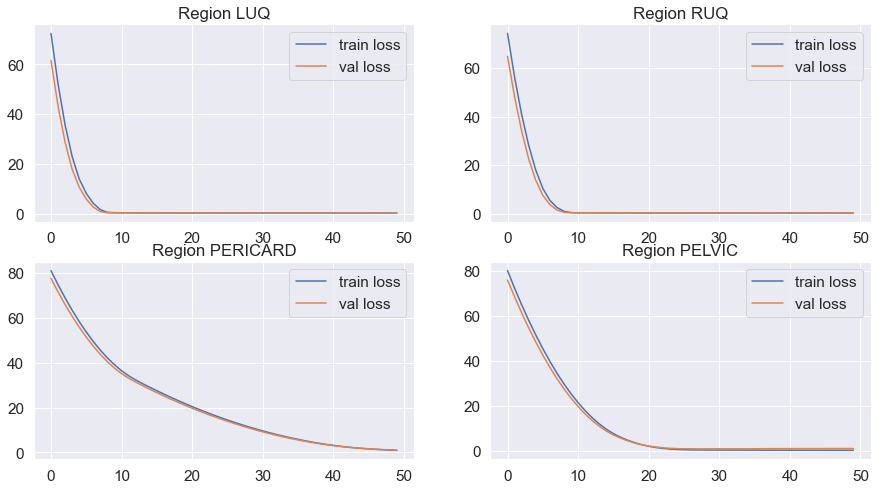

In [126]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    loss_reg = np.mean(np.array(region_avg_loss[reg]), axis=0)
    val_loss_reg = np.mean(np.array(region_avg_val_loss[reg]), axis=0)
    
    axs[i // 2, i % 2].plot(loss_reg) 
    axs[i // 2, i % 2].plot(val_loss_reg)
    axs[i // 2, i % 2].set_title(f'Region {reg.name}')
#     axs[i // 2, i % 2].set_ylim(0, 10)
    axs[i // 2, i % 2].legend(['train loss', 'val loss',], loc='best')
    
    
plt.show()
fib.savefig('./reg_avg_train.png', bbox_inches='tight', pad_inches=0)

## Stats

In [73]:
matrices = []
recall_cores = []

model = keras.models.load_model(f'best_model_{1}.tf')
train, valid, test = iterations[1]
train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_test, y_test = test
y_pred = model.predict(x_test)

y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)

recall_cores.append(recall_score(y_test, y_pred, average="macro"))
matrices.append(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()

res = score(y_test, y_pred, average='macro')
precision, recall, fscore, support = res
print(f'Model avg {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()
    
    
    

Model per class 2
precision: [0.95145631 0.99539358 0.97979798]
recall: [0.2969697  1.         0.99654592]
fscore: [0.45265589 0.99769147 0.98810099]
support: [  330  7347 11291]

Model avg 2
precision: 0.9755492895278465
recall: 0.7645052061667065
fscore: 0.8128161163656421
support: None



In [71]:
np.mean([0.99654592,1.,0.2969697 ])

0.7645052066666667

In [56]:
from sklearn.metrics import precision_recall_fscore_support as score

for i in range(6):
    model = keras.models.load_model(f'best_model_{i}.tf')
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_test, y_test = test
    y_pred = model.predict(x_test)
    
    y_test_cat = keras.utils.to_categorical(y_test)
    y_test_cat = y_test_cat.argmax(axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    precision, recall, fscore, support = score(y_test, y_pred)
    
    print(f'Model {i + 1}')
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print()


Fold 1
precision: [1.         1.         0.99544172]
recall: [0.56834532 0.99953704 1.        ]
fscore: [0.72477064 0.99976846 0.99771565]
support: [  139  6480 13758]

Fold 2
precision: [0.95145631 0.99539358 0.97979798]
recall: [0.2969697  1.         0.99654592]
fscore: [0.45265589 0.99769147 0.98810099]
support: [  330  7347 11291]



/Users/dorn_kern/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3
precision: [0.         0.96528088 0.98968242]
recall: [0.         0.99969136 0.9830644 ]
fscore: [0.         0.98218482 0.98636231]
support: [  139  6480 13758]

Fold 4
precision: [0.         0.9317008  0.99090074]
recall: [0.         1.         0.93358157]
fscore: [0.         0.96464297 0.96138755]
support: [   99 10463 11548]

Fold 5
precision: [1.         1.         0.97706819]
recall: [0.1969697 1.        1.       ]
fscore: [0.32911392 1.         0.9884011 ]
support: [  330  7347 11291]

Fold 6
precision: [0.         0.99885442 0.99149119]
recall: [0.         1.         0.99896086]
fscore: [0.         0.99942688 0.99521201]
support: [   99 10463 11548]



In [44]:
summed = np.sum(matrices, axis=0)
print(summed)
print(summed / np.sum(summed, axis=0))
print(np.sum(summed / np.sum(summed, axis=0), axis=0))

[[72143  1046     5]
 [    5 48575     0]
 [  894     0   242]]
[[9.87692013e-01 2.10797848e-02 2.02429150e-02]
 [6.84537663e-05 9.78920215e-01 0.00000000e+00]
 [1.22395334e-02 0.00000000e+00 9.79757085e-01]]
[1. 1. 1.]


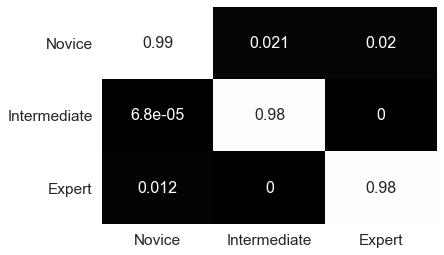

In [45]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()

In [46]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [47]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [48]:
np.mean(recall_cores)

0.720759214708757

## stats for regions

In [124]:
from sklearn.metrics import precision_recall_fscore_support as score

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'REGION: {reg}')
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        model = keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf')
        train, valid, test = iterations[i]
        train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_test, y_test = test
        y_pred = model.predict(x_test)

        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        precision, recall, fscore, support = score(y_test, y_pred)

        print(f'Fold {i + 1}')
        print('precision: {}'.format(precision))
        print('recall: {}'.format(recall))
        print('fscore: {}'.format(fscore))
        print('support: {}'.format(support))
    
    print('='*20)


REGION: Scan.LUQ


/Users/dorn_kern/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1
precision: [0.         0.89987502 0.98945052]
recall: [0.         1.         0.94759413]
fscore: [0.         0.94729917 0.9680701 ]
support: [  139  6480 13758]
Fold 2
precision: [0.         0.76956112 0.97017302]
recall: [0.         1.         0.80949429]
fscore: [0.         0.86977625 0.88258015]
support: [  330  7347 11291]
Fold 3
precision: [0.         0.69061068 0.98735674]
recall: [0.         1.         0.78899549]
fscore: [0.         0.81699552 0.87710084]
support: [  139  6480 13758]
Fold 4
precision: [0.         0.86257214 0.99448898]
recall: [0.         1.         0.85945618]
fscore: [0.         0.92621608 0.922055  ]
support: [   99 10463 11548]
Fold 5
precision: [0.         0.94035582 0.97041685]
recall: [0.         1.         0.95872819]
fscore: [0.         0.96926121 0.96453711]
support: [  330  7347 11291]
Fold 6
precision: [0.         0.97402718 0.99709711]
recall: [0.         1.         0.98155525]
fscore: [0.         0.98684273 0.98926514]
support: [   99 10463

In [128]:
matrices = []
recall_cores = []

model = keras.models.load_model(f'best_model_tuned_0_Scan.LUQ.tf')
train, valid, test = iterations[0]
train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_test, y_test = test
x_eval = model.evaluate(x_test)
y_pred = model.predict(x_test)

y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)

recall_cores.append(recall_score(y_test, y_pred, average="macro"))
matrices.append(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()

res = score(y_test, y_pred, average='macro')
precision, recall, fscore, support = res
print(f'Model avg {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()

637/637 [==============================] - 1s 2ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.0000e+00
Model per class 2
precision: [0.         0.89987502 0.98945052]
recall: [0.         1.         0.94759413]
fscore: [0.         0.94729917 0.9680701 ]
support: [  139  6480 13758]

Model avg 2
precision: 0.6297751778161869
recall: 0.6491980423511169
fscore: 0.6384564237706019
support: None



In [139]:
reg = Scan.RUQ

novices_reg, intermed_reg, experts_reg = prepared[reg]
folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)

train, valid, test = iterations[0]
train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_test, y_test = test

model = keras.models.load_model(f'best_model_tuned_0_Scan.LUQ.tf')

test_loss, test_acc = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)

print(f'Test accuracy {reg}', test_acc)
print(f'Test loss {reg}', test_loss)


y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)


print(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))

127/127 [==============================] - 1s 4ms/step - loss: 1.1894 - sparse_categorical_accuracy: 0.7339A: 0s - loss: 1.2032 - sparse_categorical_accuracy: 
Test accuracy Scan.RUQ 0.7338590621948242
Test loss Scan.RUQ 1.1893548965454102
[[ 689 1080    0]
 [   0 2289    0]
 [   0    0    0]]


In [137]:
y_pred = model.predict(x_test)

y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)


confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0])

array([[2459,    0,    0],
       [   0,  581,    0],
       [   0,    0,    0]])

In [ ]:
summed = np.sum(matrices, axis=0)
print(summed)
print(summed / np.sum(summed, axis=0))
print(np.sum(summed / np.sum(summed, axis=0), axis=0))

In [ ]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()